In [63]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import sklearn
from sklearn_pandas import DataFrameMapper
matplotlib.style.use('ggplot')
%matplotlib inline

In [23]:
df = pd.read_csv('india_surroundings_1mar2016 _28_feb_2017.csv')
del df['IRIS ID'], df['Year'], df['Month'], df['Day'], df['Time UTC'], df['Region']
df = df.iloc[::-1]

In [24]:
train_test_ratio = .8
train_size = int(df.shape[0] * train_test_ratio)
train_data = df[:train_size]
test_data = df[train_size:]

In [25]:
#mean_lat_longs = train_data.groupby('Region').mean()[['Lat','Lon']]
#replace lat_long

In [26]:
mapper = DataFrameMapper([
        (['Mag'],sklearn.preprocessing.StandardScaler()),
        (['Depth km'],sklearn.preprocessing.StandardScaler()),
        (['Lat'],sklearn.preprocessing.StandardScaler()),
        (['Lon'],sklearn.preprocessing.StandardScaler()),
        (['Timestamp'], sklearn.preprocessing.StandardScaler()) 
    ], df_out=True)
train_data = mapper.fit_transform(train_data)
train_data[['Mag','Lat','Lon','Timestamp','Depth km']] = train_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)
test_data = mapper.transform(test_data)
test_data[['Mag','Lat','Lon','Timestamp','Depth km']] = test_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)

/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


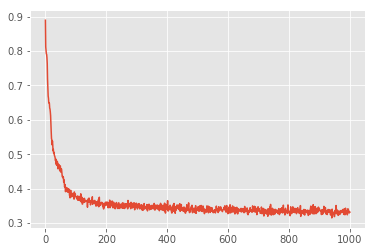

Test set loss: 0.331214


Epoch 950 avg. batch loss 0.329776


Epoch 900 avg. batch loss 0.337832


Epoch 850 avg. batch loss 0.327502


Epoch 800 avg. batch loss 0.333673


Epoch 750 avg. batch loss 0.33805


Epoch 700 avg. batch loss 0.339172


Epoch 650 avg. batch loss 0.341729


Epoch 600 avg. batch loss 0.334935


Epoch 550 avg. batch loss 0.33577


Epoch 500 avg. batch loss 0.346361


Epoch 450 avg. batch loss 0.343291


Epoch 400 avg. batch loss 0.342302


Epoch 350 avg. batch loss 0.351712


Epoch 300 avg. batch loss 0.350793


Epoch 250 avg. batch loss 0.348228


Epoch 200 avg. batch loss 0.353556


Epoch 150 avg. batch loss 0.361547


Epoch 100 avg. batch loss 0.376252


Epoch 50 avg. batch loss 0.452066


Epoch 0 avg. batch loss 0.889705


Training set loss:


In [107]:
num_epochs = 1000 
truncated_backprop_length = 15
state_size = 15 
echo_step = 3
batch_size = 4 # must be a factor of train data and test data size
num_outputs = num_features
total_series_length, num_features = train_data.shape
num_batches = total_series_length - (total_series_length//batch_size*(batch_size-1) + truncated_backprop_length-1)
num_layers = 3 
num_features = train_data.shape[1]
x = train_data.values
y = np.roll(x, echo_step)
y[0:echo_step] = np.zeros(num_features)
x = x.reshape((batch_size, -1, num_features))
y = y.reshape((batch_size, -1, num_features))

xtest = test_data.values 
ytest = np.roll(xtest, echo_step)
ytest[0:echo_step] = np.zeros(num_features)
xtest = xtest.reshape((batch_size, -1, num_features))
ytest = ytest.reshape((batch_size, -1, num_features))
total_series_length, _ = test_data.shape
num_batches_test = total_series_length - (total_series_length//batch_size*(batch_size-1) + truncated_backprop_length-1)

graph = tf.Graph()
with graph.as_default():

    batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length, num_features])
    batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length, num_features])

    init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

    state_per_layer_list = tf.unstack(init_state, axis=0)
    rnn_tuple_state = tuple([tf.contrib.rnn.core_rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
                   for idx in range(num_layers)])

    W = tf.Variable(np.random.rand(state_size+num_features, state_size), dtype=tf.float32)
    b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

    W2 = tf.Variable(np.random.rand(state_size, num_outputs),dtype=tf.float32)
    b2 = tf.Variable(np.zeros((1,num_outputs)), dtype=tf.float32)

    # Forward passes
    cell = tf.contrib.rnn.core_rnn_cell.LSTMCell(state_size, state_is_tuple=True)
    cell = tf.contrib.rnn.core_rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)
    cell = tf.contrib.rnn.core_rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)

    states_series, current_state = tf.nn.dynamic_rnn(cell, batchX_placeholder, initial_state=rnn_tuple_state)
    states_series = tf.reshape(states_series, [-1, state_size])

    outputs = tf.matmul(states_series, W2) + b2
    targets = tf.reshape(batchY_placeholder, [-1, num_features])

    losses = tf.square(tf.subtract(outputs, targets))
    total_loss = tf.reduce_mean(losses)
    step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(
        0.3,                # Base learning rate.
        step * batch_size,  # Current index into the dataset.
        300,          # Decay step.
        0.95,                # Decay rate.
    staircase=True)
    train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)



with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = [] 
    print('Training set loss:')
    for epoch_idx in range(num_epochs):

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))
        batch_loss = [] 

        for batch_idx in range(num_batches):
            start_idx = batch_idx
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:, start_idx:end_idx]
            batchY = y[:, start_idx:end_idx]

            _total_loss, _train_step, _current_state, = sess.run(
                [total_loss, train_step, current_state],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })
            
            batch_loss.append(_total_loss) 

        loss_list.append(np.mean(batch_loss))
        if epoch_idx % 50 == 0:
                print("Epoch", epoch_idx, "avg. batch loss", np.mean(batch_loss)) 
    
    _current_state = np.zeros((num_layers, 2, batch_size, state_size))
    for batch_idx in range(num_batches_test):
        start_idx = batch_idx
        end_idx = start_idx + truncated_backprop_length
        
        batchX = xtest[:, start_idx:end_idx]
        batchY = ytest[:, start_idx:end_idx]
        
        _total_loss = total_loss.run(
            feed_dict={
                batchX_placeholder: batchX,
                batchY_placeholder: batchY,
                init_state: _current_state
            })
        
        batch_loss.append(_total_loss) 

    print('Test set loss:', np.mean(batch_loss))
    plt.plot(loss_list)
    plt.show()
